In [6]:
import pandas as pd
import numpy as np
import os
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.preprocessing import StandardScaler
import joblib
import matplotlib.pyplot as plt

In [7]:
# Load your dataset
dataset_path = r"D:/Krish/Downloads/project/dataset/medicinal_herbs_adulteration_detailed_spectral_dataset.csv"  # Replace with your actual file path
df = pd.read_csv(dataset_path)
df = df.dropna()

In [8]:
# Preprocess the dataset
print("Dataset Columns:", df.columns)
print("Missing values before handling:\n", df.isnull().sum())

Dataset Columns: Index(['Sample_ID', 'Herb_Name', 'Adulterant_Present', 'Adulterant_Type',
       'Adulteration_Level', 'Spectral_Data'],
      dtype='object')
Missing values before handling:
 Sample_ID             0
Herb_Name             0
Adulterant_Present    0
Adulterant_Type       0
Adulteration_Level    0
Spectral_Data         0
dtype: int64


In [9]:
# Convert Spectral_Data from string to numeric arrays
df["Spectral_Data"] = df["Spectral_Data"].astype(str)
X_spectral = np.array(df["Spectral_Data"].str.split(",").apply(lambda x: list(map(float, x))).tolist())

# Combine Spectral_Data and Adulteration_Level as features
X = np.hstack((X_spectral, df["Adulteration_Level"].values.reshape(-1, 1)))

# Define target variable
y = df["Adulterant_Present"].values

In [10]:
# Standardize the feature set
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

In [ ]:
# Define the model
model = RandomForestClassifier(random_state=42)

# Define hyperparameter grid for GridSearchCV
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [10, 15, 20, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True, False],
    'max_features': ['auto', 'sqrt', 'log2'],
    'criterion': ['gini', 'entropy']
}

# Initialize GridSearchCV
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=5, scoring='accuracy', n_jobs=-1, verbose=2)

# Fit GridSearchCV on training data
print("Starting grid search...")
grid_search.fit(X_train, y_train)

Starting grid search...
Fitting 5 folds for each of 1296 candidates, totalling 6480 fits


c:\Users\Krish\.conda\envs\tf\lib\site-packages\sklearn\model_selection\_validation.py:425: FitFailedWarning: 
2160 fits failed out of a total of 6480.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
1402 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\Krish\.conda\envs\tf\lib\site-packages\sklearn\model_selection\_validation.py", line 732, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\Krish\.conda\envs\tf\lib\site-packages\sklearn\base.py", line 1144, in wrapper
    estimator._validate_params()
  File "c:\Users\Krish\.conda\envs\tf\lib\site-packages\sklearn\base.py", line 637, in _validate_params
    validate_parameter_constraints(
  File "c:\Users\Krish\.c

GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=42), n_jobs=-1,
             param_grid={'bootstrap': [True, False],
                         'criterion': ['gini', 'entropy'],
                         'max_depth': [10, 15, 20, None],
                         'max_features': ['auto', 'sqrt', 'log2'],
                         'min_samples_leaf': [1, 2, 4],
                         'min_samples_split': [2, 5, 10],
                         'n_estimators': [100, 200, 300]},
             scoring='accuracy', verbose=2)

In [12]:
# Retrieve the best model
best_model = grid_search.best_estimator_
print(f"Best Parameters: {grid_search.best_params_}")

Best Parameters: {'bootstrap': True, 'criterion': 'gini', 'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}


In [13]:
# Evaluate the model on the test set
y_pred = best_model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Test Set Accuracy: {accuracy:.2%}")

Test Set Accuracy: 100.00%


In [15]:
# Save the best model and scaler for future use

joblib.dump(best_model, r"D:/Krish/Downloads/project/SavedModels/RandomForest/random_forest_best_model.pkl")
joblib.dump(scaler, r"D:/Krish/Downloads/project/SavedModels/RandomForest/scaler.pkl")

['D:/Krish/Downloads/project/SavedModels/RandomForest/scaler.pkl']

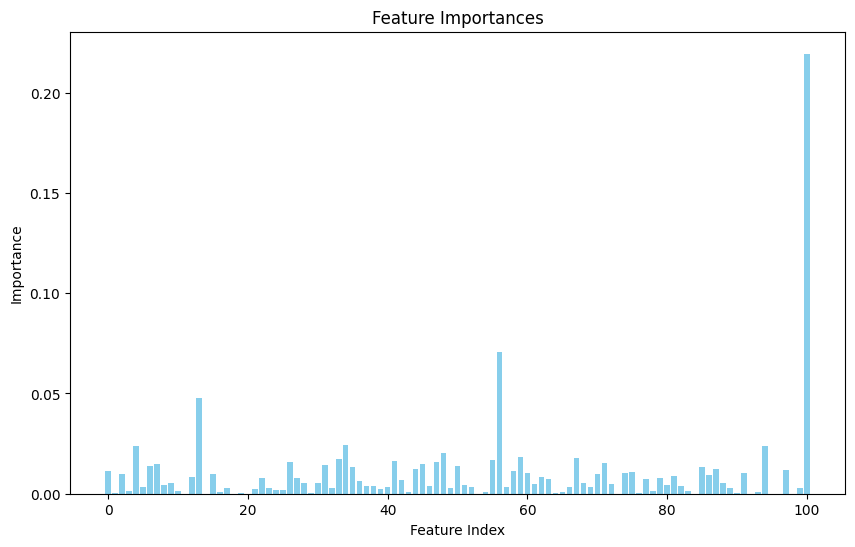

In [16]:
# 1. Plot Feature Importance
feature_importances = best_model.feature_importances_
plt.figure(figsize=(10, 6))
plt.bar(range(len(feature_importances)), feature_importances, color='skyblue')
plt.title("Feature Importances")
plt.xlabel("Feature Index")
plt.ylabel("Importance")
plt.show()

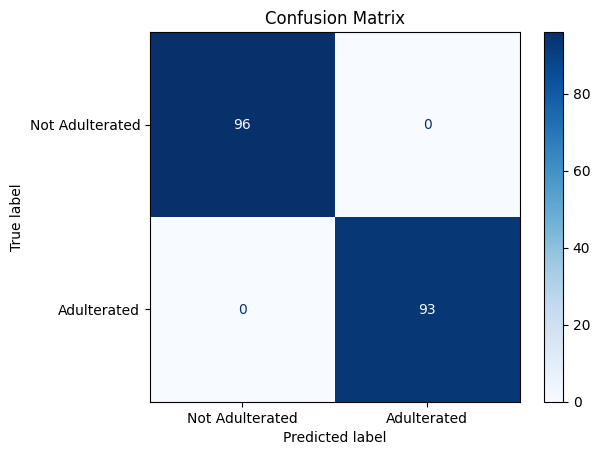

In [17]:
# 2. Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=["Not Adulterated", "Adulterated"])
disp.plot(cmap="Blues", values_format="d")
plt.title("Confusion Matrix")
plt.show()

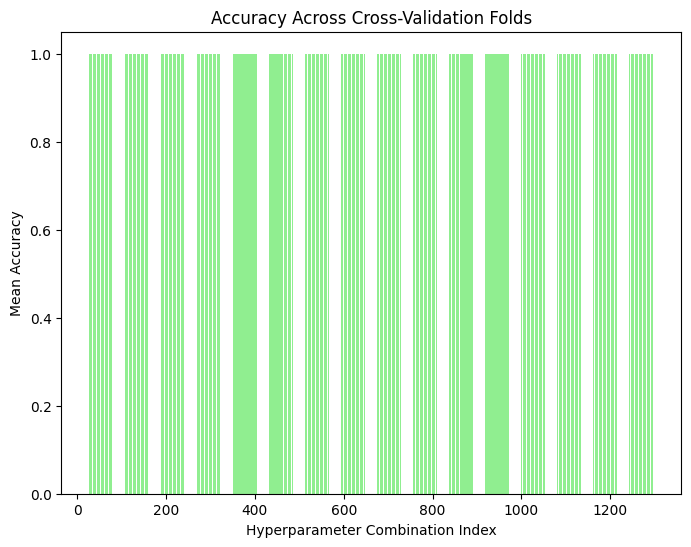

In [18]:
# 3. Accuracy Across Folds
cv_results = pd.DataFrame(grid_search.cv_results_)
mean_test_scores = cv_results["mean_test_score"]
plt.figure(figsize=(8, 6))
plt.bar(range(1, len(mean_test_scores) + 1), mean_test_scores, color='lightgreen')
plt.title("Accuracy Across Cross-Validation Folds")
plt.xlabel("Hyperparameter Combination Index")
plt.ylabel("Mean Accuracy")
plt.show()